# Fake News Identification: Machine Learning and Deep Learning Approaches.

In this project, I aim to differentiate between dirty and clean plates using machine learning. The dataset, sourced from a Kaggle competition. 
<br>I will utilize transfer learning to leverage pre-trained models, enhancing classification accuracy. 
<br>After training, I will implement an active learning approach, where I will select samples with the highest likelihood predictions from 
<br>an unlabeled dataset. These selected samples will then be labeled and added to the training set, allowing me to iteratively improve the model. 
<br>Ultimately, I will submit the predictions on the Kaggle platform and apply the trained model to my own images of plates to assess 
<br>its performance in real photos by uploading here.

<br> Data set is provided form [`Kaggle Breast Ultrasound Images Dataset(BUSI)`](https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset)

## Outline
- [ 1 - Import Data](#1)
- [ 2 - ML models](#2)
  - [ 2.1 - SVM](#2.1)
  - [ 2.2 - Naive Bayes](#2.2)
  - [ 2.3 - Logistic Regression](#2.3)
- [ 3 - Neuron networks](#3)
  - [ 3.1 - Convolutional NN](#3.1)
  - [ 3.2 - LSTM](#3.2)
  - [ 3.3 - Bidirectional LSTM](#3.3)
- [ 4 - Fine-Tuning (DistilBert)](#4)

<a name="1"></a>
## 1 - Import Data

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import display
from IPython.display import Image as image
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os,glob, re
from PIL import Image
import pandas as pd
import random
import shutil
import cv2
from ipywidgets import widgets
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set memory growth BEFORE initializing any TensorFlow operations
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
        print(f"Memory growth enabled for {device}")
    except RuntimeError as e:
        # Memory growth must be set before TensorFlow operations are initialized
        print(f"Error enabling memory growth for {device}: {e}")

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
seed = 42
tf.random.set_seed(seed)

In [4]:
class_names = ["benign", "malignant", "normal"]
train_path = "/Users/sergeiakhmadulin/Documents/Braest Censer/Train/"
test_path = "/Users/sergeiakhmadulin/Documents/Braest Censer/Test/"

In [5]:
# Iterate through the files in the directory
for class_name in class_names:
    for filename in os.listdir(train_path + class_name):
        # Construct full file path
        file_path = os.path.join(train_path + class_name, filename)
        
        # Check if the file name contains "_mask"
        if "_mask" in filename and os.path.isfile(file_path):
            # Delete the file
            os.remove(file_path)

In [6]:
def polt_pie_data(path, labels):
    num_data = {}
    for class_name in class_names:
        image_files = os.listdir(path + class_name)
        filtered_files = [file for file in image_files if '_mask' not in os.path.basename(file)]
        num_data[class_name] = len(filtered_files)
        
    labels = list(num_data.keys())
    sizes = list(num_data.values())
    
    def autopct_with_counts(pct, allsizes):
        absolute = int(pct / 100. * sum(allsizes))  # Calculate absolute count
        return f"{absolute}\n({pct:.1f}%)"
        
    fig, ax = plt.subplots(figsize=(8,6))
    wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: autopct_with_counts(pct, sizes), startangle=90)
    
    ax.axis('equal')
    ax.set_title('Proportion of Labels in Train Dataset')
    ax.legend(wedges, labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()

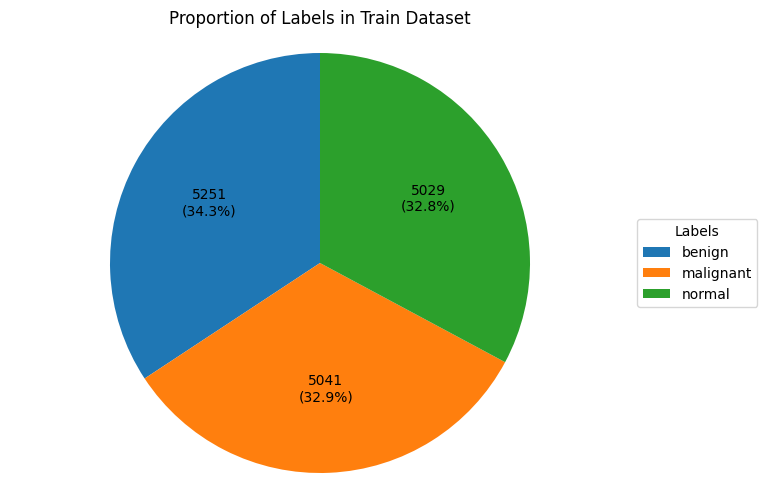

In [8]:
polt_pie_data(train_path, class_names)

In [9]:
def show_some_images(path, class_name, augmented = False, name_table = "Original"):
    """
    Function that shows 4 images for given path and class name

    Parameters:
    path: location for folders of classes with images
    class_name: variable of given names of classes
    augmented: flag of augmentation
    name_table: table name that indicates wather images are original or augmentated

    Outputs:
    Nothing, just shows images
    """
    full_path = path + class_name
    files = os.listdir(full_path)
    files = [file for file in files if '_mask' not in os.path.basename(file)]

    if augmented:
        files = [file for file in files if 'augmented_image_' in os.path.basename(file)]


    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    fig.suptitle(f'{name_table} images of class: {class_name}', fontsize=16)

    for i, image in enumerate(files[:4]):
        img = load_img(full_path + "/" + image)
        axes[i].imshow(img)
        axes[i].set_title(f'Example {class_name} {i}')
    
    plt.show()

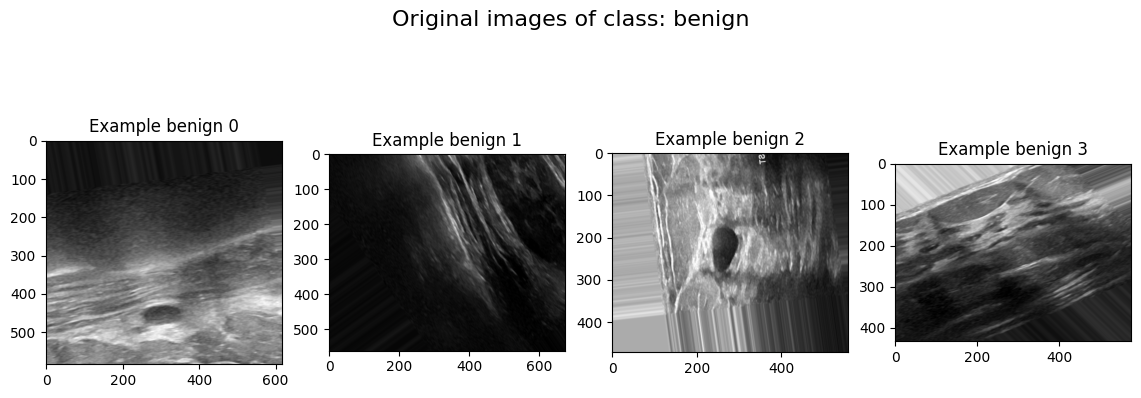

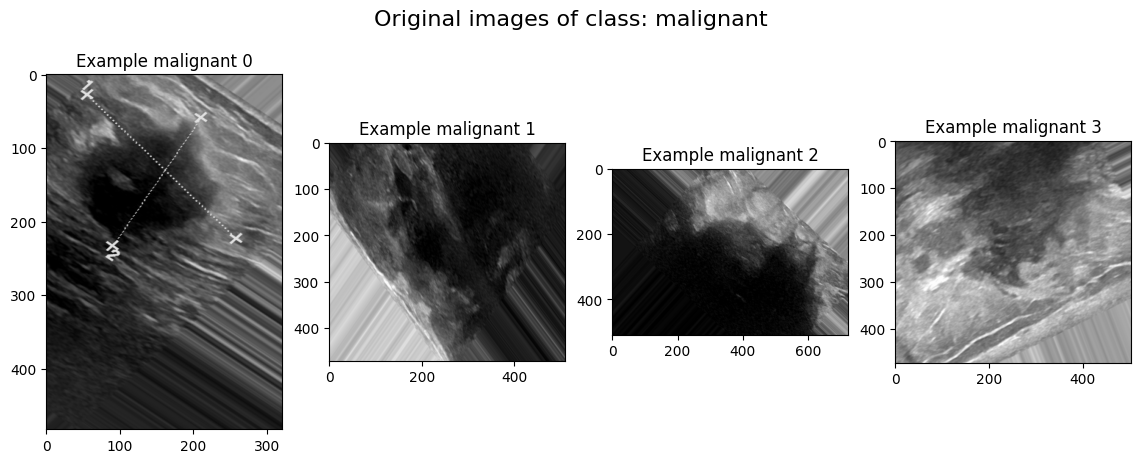

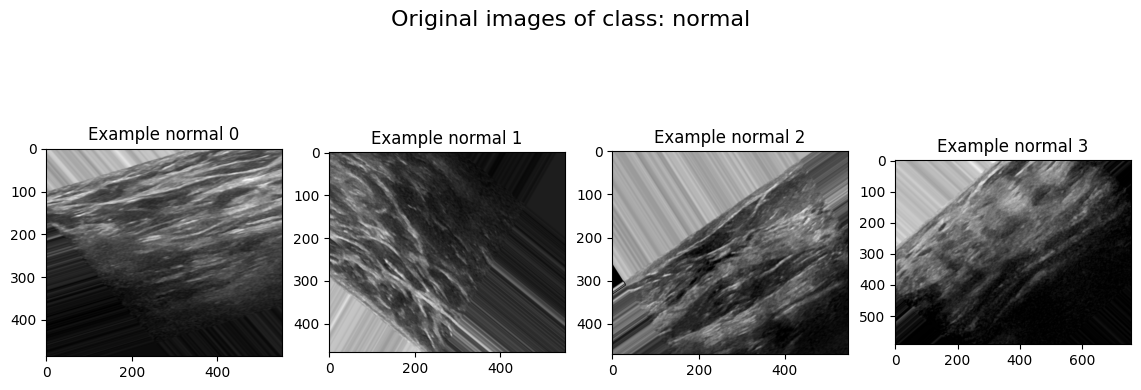

In [10]:
for i in class_names:
    show_some_images(train_path,i)

In [56]:
def move_random_files(source_folder, destination_folder, ratio_for_val):
    """
    Function that moves random images of each classes, holding given ratio of validation set, from train folder to validation folder.

    Parameters:
    source_folder: directory for the training data folder from which images will be removed
    destination_folder: directory where images will be stored
    ratio_for_val: which part goes to validation set 

    Outputs:
    Nothing, just moves images
    """
    
    for class_name in class_names:
        full_path_source = source_folder + class_name + "/"
        full_destination_folder = destination_folder + class_name + "/"
        os.makedirs(full_destination_folder, exist_ok=True)
        files = os.listdir(full_path_source)
        
        whole_part = int(len(files) * ratio_for_val)
        # Randomly select the specified number of files
        if len(files) < whole_part:
            print(f"Not enough files to choose from. Available: {len(files)}")
            return
    
        selected_files = random.sample(files, whole_part)
        print(selected_files)
        # Move each selected file to the destination folder
        for file_name in selected_files:
            shutil.move(os.path.join(full_path_source, file_name), os.path.join(full_destination_folder, file_name))
    print(f'Moved {len(selected_files)} files of each class to validation folder')

In [ ]:
move_random_files(train_path, val_path, 0.2)

In [11]:
def add_gaussian_noise(image):
    """
    Function that add some noise to original image.

    Parameters:
    image: given image

    Outputs:
    Image with noise
    """
    
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_image = image + noise
    return noisy_image


def preprocess_image(image):
    """
    Function that perform random transformations from list on images (noise, grayscale, brightness or none).

    Parameters:
    image: given image

    Outputs:
    Transformed image
    """
    transform_choice = np.random.choice(['none', 'noise'])
    if transform_choice == 'noise':
        image = add_gaussian_noise(image)
    elif transform_choice == 'grayscale':
        image = tf.image.rgb_to_grayscale(image)
    elif transform_choice == 'brightness':
        image = tf.image.random_brightness(image, max_delta=0.2)

    return image

In [12]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,    
    rotation_range=90,
    vertical_flip=True,
    channel_shift_range = 0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [118]:
def generate_augm_data(datagen_function, folder, num_of_img, classes):
    """
    Function that add a given ammount of augmentated images to the folder with original.

    Parameters:
    datagen_function: ImageDataGenerator with banch of transformations
    folder: directory with images for augmentation
    num_of_img: numbers of additional images to be generated
    classes: list of given class names

    Outputs:
    Augmented images in folder
    """
    print("Augmantation started...")
    for class_name in classes:
        full_path = folder + class_name + "/"
        original_images = []  # List to hold original images
        files = os.listdir(full_path)
        orig_files = [file for file in files if 'augmented_image_' not in os.path.basename(file)]
        for num_img, filename in enumerate(orig_files):
            img = Image.open(os.path.join(full_path, filename))
            original_images.append(np.array(img))
        num_of_original_images = num_of_img - len(files)
        print(f"\nFound images of class {class_name}: {len(orig_files)}")
        num_of_each_img = num_of_original_images//len(original_images)
        num_of_new = 0
        for num_orig, img in enumerate(original_images):
            img = img.reshape((1,) + img.shape)  # Reshape for the generator
            current_count = 0
            for num_augm, batch in enumerate(datagen.flow(img, batch_size=1)):
                augmented_image = batch[0].astype(np.uint8)
                # Save or process your augmented images
                Image.fromarray(augmented_image).save(full_path + f'augmented_image_{files[num_orig]}_{num_augm}.png')
                current_count += 1
                num_of_new += 1
                if current_count >= num_of_each_img:
                    break
        print(f"Add new augmented images of class {class_name}: {num_of_new}")
    print("\nAugmentation finished.")

In [119]:
generate_augm_data(datagen, train_path, 10000, class_names)

Augmantation started...

Found images of class benign: 350
total images 5250
Add new augmented images of class benign: 4550

Found images of class malignant: 168
total images 5040
Add new augmented images of class malignant: 4872

Found images of class normal: 107
total images 5029
Add new augmented images of class normal: 4922

Augmentation finished.


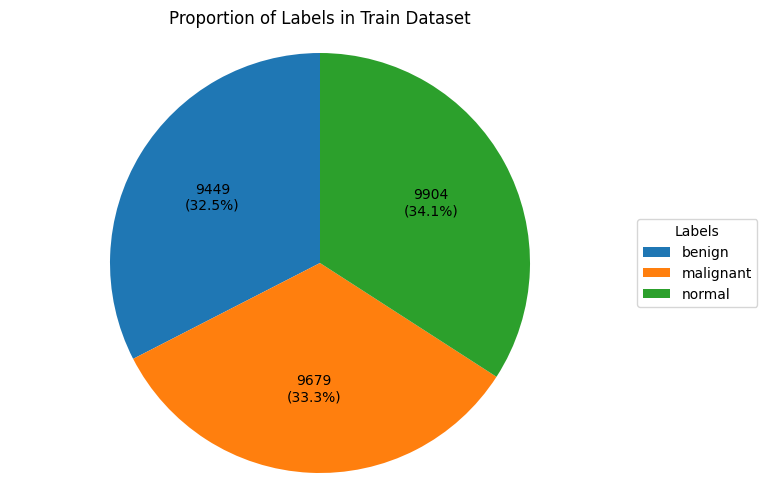

In [120]:
polt_pie_data(train_path, class_names)

In [14]:
generate_augm_data(datagen, test_path, 700, class_names)

Augmantation started...
/Users/sergeiakhmadulin/Documents/Braest Censer/Test/benign/

Found original images of class benign: 87


2024-12-10 19:54:26.134953: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-10 19:54:26.135001: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-10 19:54:26.135005: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-10 19:54:26.135031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 19:54:26.135044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Add new augmented images of class benign: 696
/Users/sergeiakhmadulin/Documents/Braest Censer/Test/malignant/

Found original images of class malignant: 42
Add new augmented images of class malignant: 672
/Users/sergeiakhmadulin/Documents/Braest Censer/Test/normal/

Found original images of class normal: 26
Add new augmented images of class normal: 676

Augmentation finished.


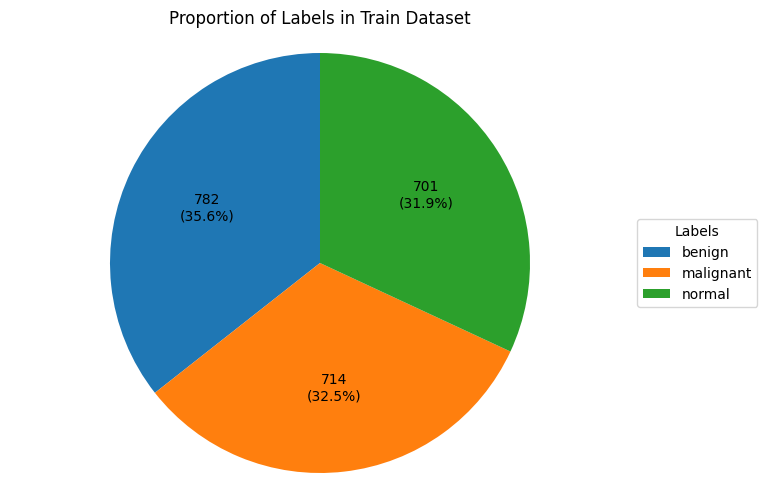

In [15]:
polt_pie_data(test_path, class_names)

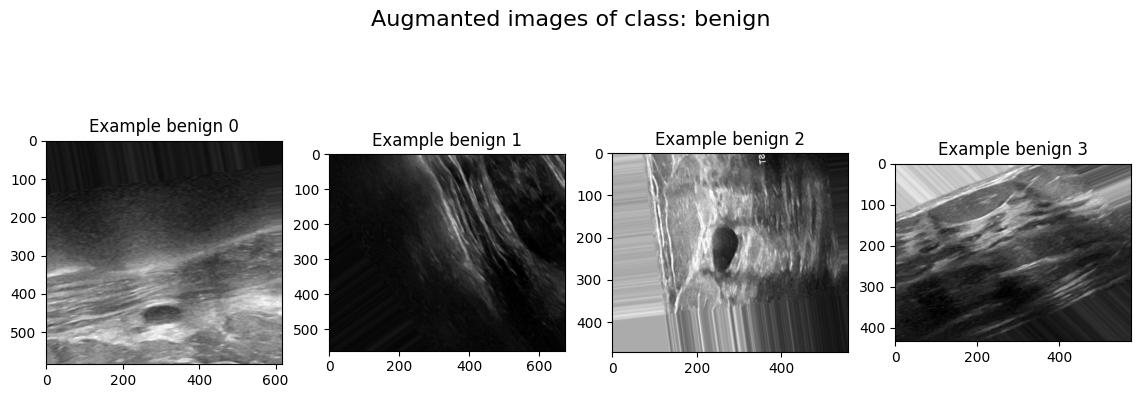

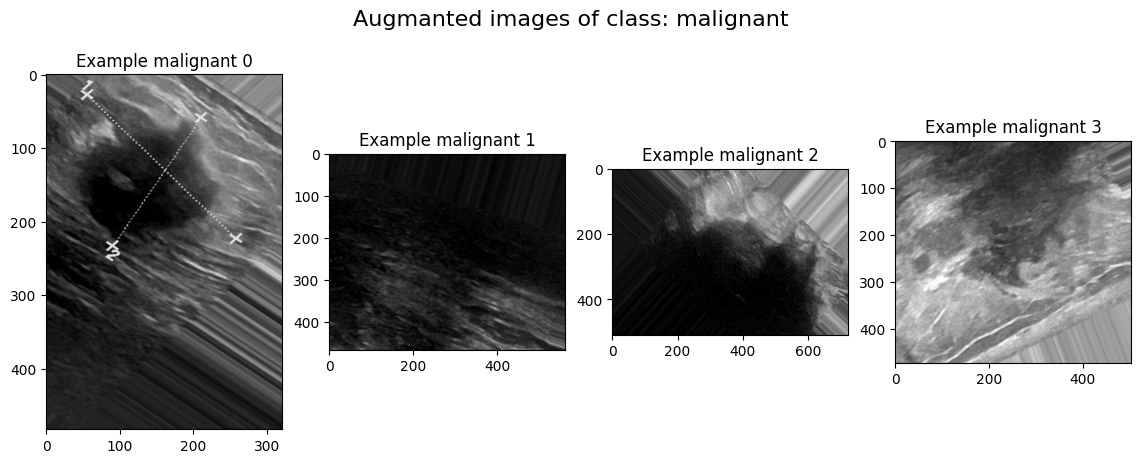

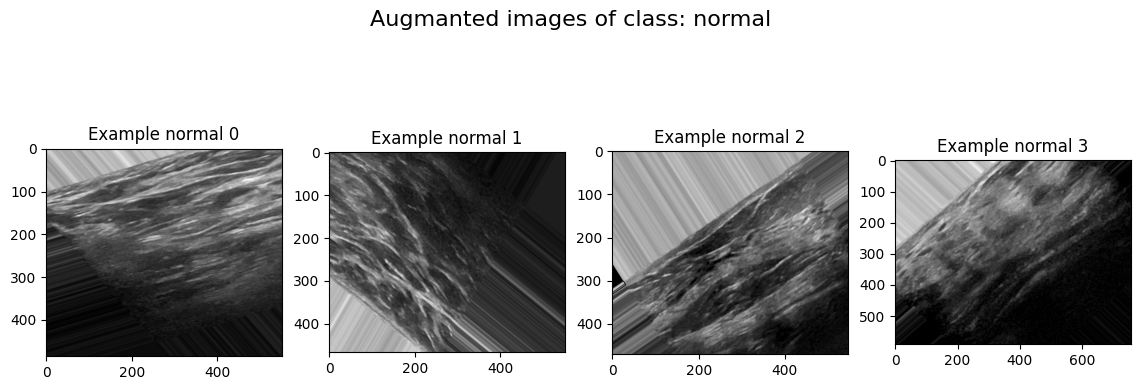

In [25]:
for i in class_names:
    show_some_images(train_path,i, augmented=True, name_table = "Augmented")

In [11]:
def train_val_datasets(train_path, test_path):
    """
    Creates datasets for training and validation.
    
    Parameters:
    train_path: directory of training folder
    val_path: directory of validation folder
    
    Returns:
    (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_path,
        batch_size=10,
        image_size=(224, 224),
        shuffle=True,
        seed=seed
    )
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=test_path,
        batch_size=10,
        image_size=(224, 224),
        shuffle=True,
        seed=seed
    )

    return training_dataset, validation_dataset

In [30]:
def create_pre_trained_model():
    """
    Creates the pretrained EfficientNetB0 model

    Returns:
    tf.keras.Model: pre-trained model
    
    """
    
    pre_trained_model = tf.keras.applications.EfficientNetB0(
        include_top=False,  # Remove the fully connected layer
        input_shape=(224, 224, 3),
        weights='imagenet'  # Use pre-trained weights
    )
    pre_trained_model.trainable = False  # Freeze the base model

    return pre_trained_model

In [31]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    """
    Class of callback that contains cases for stopping model training

    patience: number of epoch to wait until improvement in test accuracy
    """
    def __init__(self, patience=5):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_accuracy = 0.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        
        if current_accuracy is None:
            return
        
        if current_accuracy - self.best_accuracy >= 0.03: # differense in current test accuracy and best grather or equals to 3% 
            self.best_accuracy = current_accuracy
            self.wait = 0
            print(f"New best accuracy: {self.best_accuracy:.4f}")
        else:
            self.wait += 1
            print(f"No improvement in epoch {epoch + 1}. Waiting {self.wait}/{self.patience}...")

        if self.wait >= self.patience:
            print("Early stopping triggered!")
            self.model.stop_training = True

        if logs['accuracy'] >= 0.99 and logs['val_accuracy'] >= 0.99: # earlystopping
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [32]:
checkpoint = ModelCheckpoint(
    'best_model_EfficientNetB0_base_1.keras',               # File name to save the model
    monitor='val_accuracy',         # Metric to monitor
    save_best_only=True,           # Save only the best model
    mode='max',                    # Mode (max for accuracy)
    verbose=1                      # Verbosity
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',       # Metric to monitor
    factor=0.2,               # Factor by which the learning rate will be reduced
    patience=2,               # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,              # Minimum learning rate
    verbose=1
)

In [33]:
seed = 42

# Load datasets
training_dataset, validation_dataset = train_val_datasets(train_path, test_path)

# Create base model
base_model = create_pre_trained_model()

Found 15319 files belonging to 3 classes.
Found 2199 files belonging to 3 classes.


In [36]:
def run_training(model,danse_neurons,dropout,learning_rate,epochs,patience):
    # Build the model
    model = models.Sequential([
        model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(danse_neurons, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(3, activation='softmax')  # Output layer for 3 classes
    ])
    
    # Compile the model with sparse_categorical_crossentropy for integer-encoded labels
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        verbose=1,
        callbacks = [EarlyStoppingCallback(patience=patience),checkpoint,reduce_lr]
    )

In [37]:
run_training(base_model,1028,0.5,0.0015,5,3)

Epoch 1/5
New best accuracy: 0.6567

Epoch 1: val_accuracy improved from 0.65484 to 0.65666, saving model to best_model_EfficientNetB0_base_1.keras
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 114s 72ms/step - accuracy: 0.5494 - loss: 1.5867 - val_accuracy: 0.6567 - val_loss: 0.8806 - learning_rate: 0.0015
Epoch 2/5
New best accuracy: 0.7349

Epoch 2: val_accuracy improved from 0.65666 to 0.73488, saving model to best_model_EfficientNetB0_base_1.keras
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 105s 68ms/step - accuracy: 0.6106 - loss: 1.5606 - val_accuracy: 0.7349 - val_loss: 0.8426 - learning_rate: 0.0015
Epoch 3/5
No improvement in epoch 3. Waiting 1/3...

Epoch 3: val_accuracy did not improve from 0.73488
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 105s 68ms/step - accuracy: 0.6196 - loss: 1.7461 - val_accuracy: 0.7340 - val_loss: 0.8636 - learning_rate: 0.0015
Epoch 4/5
No improvement in epoch 4. Waiting 2/3...

Epoch 4: val_accuracy did not improve from 0.73488

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00

In [38]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
run_training(base_model,256,0.5,0.0005,5,3)

Epoch 1/5
 390/1532 ━━━━━━━━━━━━━━━━━━━━ 3:58 209ms/step - accuracy: 0.7588 - loss: 0.5708